# Proyecto final

#### 1-3) [Lectura de datos](#primero)
#### 4-8) [Procesamiento de datos y regularización](#segundo)
#### 9-13.3) [Implementación de modelos y análisis de precisión](#tercero)
#### 14-16) [Mejores modelos y predicciones datos de prueba](#cuarto)
#### 17-18) [Resultados y conclusiones](#quinto)
#### [Referencias](#sexto)

Estos son todos los paquetes empleados para la implementación:

In [45]:
%pylab inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn import svm

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
%matplotlib inline


Populating the interactive namespace from numpy and matplotlib


## Lectura de datos <a name="primero"></a>

**1)** Se importan los datos suministrados por [Kaggle](https://www.kaggle.com/c/titanic/data)

In [46]:
data_train = pd.read_csv(os.path.join('.','train.csv'))
data_test = pd.read_csv(os.path.join('.','test.csv'))

**2)** Para ver el formato en el que vienen los datos:

In [47]:
data_train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
557,558,0,1,"Robbins, Mr. Victor",male,NaN,0,0,PC 17757,227.5250,NaN,C
348,349,1,3,"Coutts, Master. William Loch ""William""",male,3.0,1,1,C.A. 37671,15.9000,NaN,S
764,765,0,3,"Eklund, Mr. Hans Linus",male,16.0,0,0,347074,7.7750,NaN,S
257,258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,B77,S
572,573,1,1,"Flynn, Mr. John Irwin (""Irving"")",male,36.0,0,0,PC 17474,26.3875,E25,S
834,835,0,3,"Allum, Mr. Owen George",male,18.0,0,0,2223,8.3000,NaN,S
715,716,0,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,0,0,348124,7.6500,F G73,S
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9000,NaN,S
308,309,0,2,"Abelson, Mr. Samuel",male,30.0,1,0,P/PP 3381,24.0000,NaN,C
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q


**3)** Se pueden usar diferentes tipos de gráficas para visualizar los diferentes datos, y así tener una primera aproximación a la relación entre las características y la supervivencia de cada pasajero.

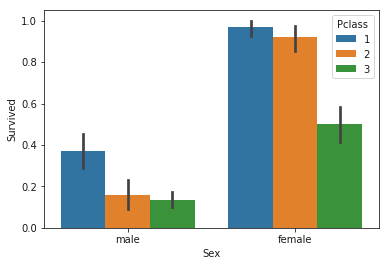

In [48]:
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=data_train);

**3.1)** En esta gráfica se puede evidenciar que tanto para los hombres como para las mujeres, los de primera clase tuvieron una tasa de supervivencia mayor y esta decrece a medida que la clase aumenta. Como era de esperar, las mujeres tuvieron un indice de supervivencia mayor que los hombres en todas las clases.

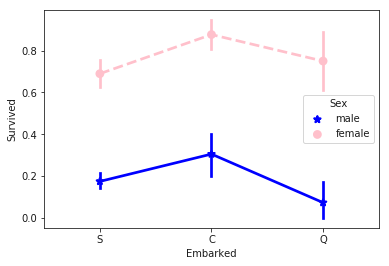

In [49]:
sns.pointplot(x="Embarked", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

**3.2)** Con esta gráfica se busca definir si hay relación entre el lugar de embarcación y la tasa de supervivencia. Los datos indican que, en general, los que embarcaron en C (Cherbourg) tuvieron mayor promedio de supervivencia.

## Procesamiento de datos y regularización <a name="segundo"></a>

**4)** Se modifican algunas características suministradas para simplificarlas o para organizarlas de manera más efectiva.

**4.1)** Para las edades se crean grupos dados los rango de edades suministrados:

In [50]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df


**4.2)** Para la característica de cabinas se elije únicamente el primer elemento, que corresponde a la letra de la zona en la que se encontraba la cabina y se asume que el número es irrelevante.

In [51]:
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

**4.3)** Para las tarifas que pagó cada persona se hace un análisis etadístico y se agrupan dependiendo el cuartil al que pertenezcan.

In [52]:
def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

**4.4)** Para los nombres se va a tener en cuenta únicamente el apellido y el prefijo como (Mr., Mrs., etc.). **En el código original se separaban los atributos según los espacios, pero esto fallaba para apellidos compuestos como Vander Cruyssen, por lo tanto, se implementa este código corregido**.

In [53]:
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(',')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(',')[1])
    df['NamePrefix'] = df.NamePrefix.apply(lambda x: x.split(' ')[1])
    return df    

**4.5)** Por último se eliminan datos que no se incluiran en el análisis como número de tiquete y nombre. [En el código original se quitaba también el lugar de embarcación, pero dada la gráfica en **3.2)** se decide dejar esta característica].

In [54]:
def fix_embarked(df):
    df.Embarked = df.Embarked.fillna('U')
    return df

In [55]:
def drop_features(df):
    return df.drop(['Ticket', 'Name'], axis=1)

**5)** Se implementa una función general para realizar todo el manejo de los datos.

In [56]:
def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = fix_embarked(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

In [57]:
data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_test.sample(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
365,1257,3,female,Unknown,1,9,4_quartile,N,S,Sage,Mrs.
325,1217,3,male,Student,0,0,1_quartile,N,S,Assam,Mr.
118,1010,1,male,Adult,0,0,4_quartile,C,C,Beattie,Mr.
351,1243,2,male,Student,0,0,2_quartile,N,S,Stokes,Mr.
360,1252,3,male,Teenager,8,2,4_quartile,N,S,Sage,Master.


**6)** Se muestran los resultados de la simplificación en las siguientes gráficas.

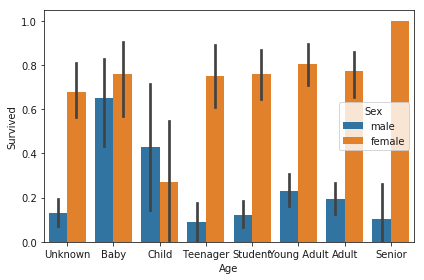

In [58]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train)
plt.tight_layout();

**6.1)** En la gráfica de rango de edad contra el promedio de supervivencia, el primer elemento relevante es que todas las mujeres mayores de 60 años sobrevivieron y, en general, las mujeres presentan un mayor promedio de supervivencia, excepto para las niñas (child, en el rango entre 5-12 años).

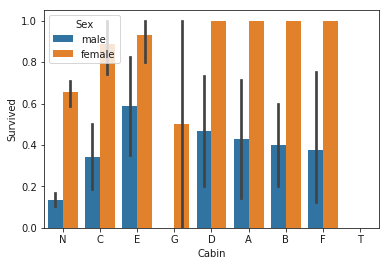

In [59]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

**6.2)** Para los datos de la cabina ocupada, todas las mujeres en las cabinas D,A,B, y F sobrevivieron puede ser por dos razones, la primera es que fueran mujeres pertenecientes a la primera clase y se les otorgara algún tipo de prioridad o la segunda es que hayan estado más cerca a los botes salvavidas. 

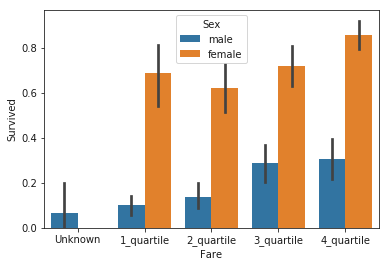

In [60]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);

**6.3)** En esta gráfica de tarifa contra tasa de supervivencia se hace más evidente la relación entre el precio pagado (relacionado con la clase) y  la supervivencia de los pasajeros, especialemente en los hombres, que a medida que aumenta la tarifa la tasa de supervivencia aumenta. Para los casos desconocidos se asume que son personas que se colaron, razón por la cual era muy poco probable que recibieran un cupo en los botes salvavidas.

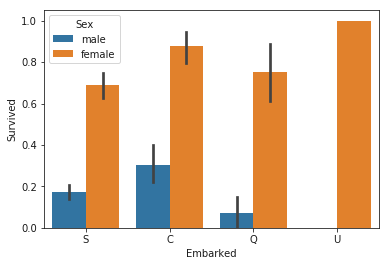

In [61]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

**6.4)** En la gráfica de lugar de embarcación contra supervivencia, se puede ver que los promedios más altos se encuentran para aquellas personas que embarcaron en C (Cherbourg, Francia) por lo tanto, a diferencia del código original, se decide incluir esta característica en el análisis.

**7)** Una forma de regularizar los datos es empleando el módulo de codificación de etiquetas del paquete de scikit-learn, que otorga valores numéricos a las categorias creadas anteriormente.

In [62]:
def encode_features(df_train, df_test):
    features = ['Fare', 'Age', 'Cabin', 'Sex', 'Lname', 'NamePrefix', 'Embarked']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

In [63]:
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,2,100,12
1,2,1,1,0,0,1,0,3,2,0,182,13
2,3,1,3,0,7,0,0,0,7,2,329,9
3,4,1,1,0,7,1,0,3,2,2,267,13
4,5,0,3,1,7,0,0,1,7,2,15,12


**8)** Debido a que los datos de prueba (test) no contienen un valor de supervivencia para poder verificar la precisión del modelo, se realiza una partición de los datos de entrenamiento de tal forma que el entrenamiento del modelo se realizará sobre el 80% de estos, mientras que el 20% restante se usarán para medir la precisión del mismo.

In [64]:
X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test)

## Implementación de modelos y análisis de precisión <a name="tercero"></a>

**9)** El primer clasificador a usar será Random Forest Classifier, el cual funciona diseñando un conjunto de árboles de decisión para encontrar cómo influyen las características en el resultado final. En este caso, implica que una "hoja" define la supervivencia del pasajero.
Entre los parámetros principales están:
- n_estimators, que define el número de árboles en el bosque.
- max_features, que define el máximo número de características a emplear.
- criterion, que define el método de creación de los árboles (gini, por default, o entropy).
- max_depth, que define la profundidad del árbol.
- min_samples_split, que define el mínimo número de muestras requerido para dividir un nodo interior.
- min_samples_leaf, que es el mínimo número de muestras requeridos en una hoja.


In [65]:
# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [7, 8, 10], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [11, 12, 13, 14], 
              'min_samples_split': [6, 7, 8],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**10)** Una vez se ha ajustado el modelo a los datos, se procede a realizar la predicción, para luego verificar la precisión del resultado, en comparación con el 20% de los datos ya mencionados.

In [66]:
RFpredictions = clf.predict(X_test)
print(accuracy_score(y_test, RFpredictions))

0.804469273743


**11)** Ahora, se probarán diferentes modelos para comparar y obtener una mejor precisión. Para cada método se dejan los parámetros que por default se tienen, a diferencia del procedimiento recién realizado.

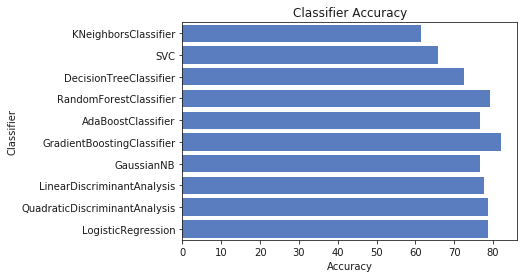

In [67]:
#Clasificadores a usar
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log1  = pd.DataFrame(columns=log_cols)

acc_dict1 = {}


#Se realiza ajuste y predicción para cada método
for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    if name in acc_dict1:
        acc_dict1[name] += acc
    else:
        acc_dict1[name] = acc

# Graficación de resultados        
for clf in acc_dict1:
    acc_dict1[clf] = acc_dict1[clf]*100
    log_entry = pd.DataFrame([[clf, acc_dict1[clf]]], columns=log_cols)
    log1 = log1.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log1, color="b");

In [68]:
log1

,Classifier,Accuracy
0,KNeighborsClassifier,61.452514
0,SVC,65.921788
0,DecisionTreeClassifier,72.625698
0,RandomForestClassifier,79.329609
0,AdaBoostClassifier,76.536313
0,GradientBoostingClassifier,82.122905
0,GaussianNB,76.536313
0,LinearDiscriminantAnalysis,77.653631
0,QuadraticDiscriminantAnalysis,78.770950
0,LogisticRegression,78.770950


**11.1)** Como se puede ver en la gráfica y en la tabla que resume los resultados de cada método se determina que los tres parametros con mayor índice de precisión son, de mayor a menor: **1. Gradient Boost Classifier** , **2. Decision Tree Classifier** , **3. Random Forest Classifier**

**12)** Ahora, si se desea aumentar la precisión del modelo, se requiere reevaluar el preprocesamiento de la información. Para esto, se tomó como referencia el [código de Manav Sehgal](https://www.kaggle.com/startupsci/titanic-data-science-solutions), que considera importante el hecho estar o no con familiares a bordo.

In [69]:
def simplify_family(df):
    df['FamSize']=df['SibSp']+df['Parch']+1
    df['IsAlone']=0
    df.loc[df['FamSize']==1,'IsAlone']=1
    return df

In [70]:
simplify_family(data_train)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Lname,NamePrefix,FamSize,IsAlone
0,1,0,3,1,4,1,0,0,7,2,100,12,2,0
1,2,1,1,0,0,1,0,3,2,0,182,13,2,0
2,3,1,3,0,7,0,0,0,7,2,329,9,1,1
3,4,1,1,0,7,1,0,3,2,2,267,13,2,0
4,5,0,3,1,7,0,0,1,7,2,15,12,1,1


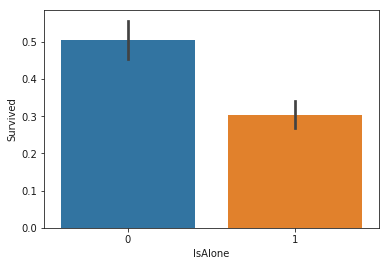

In [71]:
sns.barplot(x="IsAlone", y="Survived", data=data_train);

**12.1)** Para aseguranos de que este nuevo elemento fuera relevante quisimos graficar la relación entre el hecho de que el pasajero viajara solo y la tasa de supervivencia. En esta gráfica podemos obesvar que la tasa de supervivecia de aquellos que viajaban acompañados fue mayor.

In [72]:
def drop_features2(df): 
    return df.drop(['SibSp', 'Parch','FamSize'], axis=1)

In [73]:
data_train2 = drop_features2(data_train)
data_train2.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Lname,NamePrefix,IsAlone
0,1,0,3,1,4,0,7,2,100,12,0
1,2,1,1,0,0,3,2,0,182,13,0
2,3,1,3,0,7,0,7,2,329,9,1
3,4,1,1,0,7,3,2,2,267,13,0
4,5,0,3,1,7,1,7,2,15,12,1


In [74]:
X_all2 = data_train2.drop(['Survived', 'PassengerId'], axis=1)
y_all2 = data_train2['Survived']
num_test = 0.20
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_all2, y_all2, test_size=num_test)

**13)** Una vez se han modificado los datos se vuelve a crear el modelo para evaluar si mejoró en algo el resultado

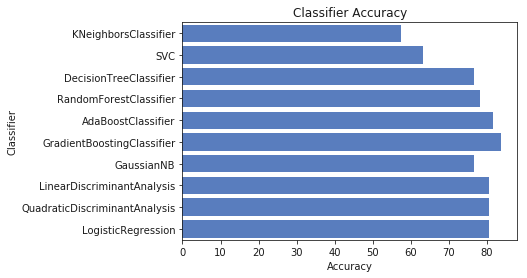

In [75]:
log_cols = ["Classifier", "Accuracy"]
log2  = pd.DataFrame(columns=log_cols)

acc_dict2 = {}


#Se realiza ajuste y predicción para cada método
for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train2, y_train2)
    train_predictions2 = clf.predict(X_test2)
    acc = accuracy_score(y_test2, train_predictions2)
    if name in acc_dict2:
        acc_dict2[name] += acc
    else:
        acc_dict2[name] = acc
    
   
# Graficación de resultados        
for clf in acc_dict2:
    acc_dict2[clf] = acc_dict2[clf]*100
    log_entry = pd.DataFrame([[clf, acc_dict2[clf]]], columns=log_cols)
    log2 = log2.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log2, color="b");

In [76]:
log2

,Classifier,Accuracy
0,KNeighborsClassifier,57.541899
0,SVC,63.128492
0,DecisionTreeClassifier,76.536313
0,RandomForestClassifier,78.212291
0,AdaBoostClassifier,81.564246
0,GradientBoostingClassifier,83.798883
0,GaussianNB,76.536313
0,LinearDiscriminantAnalysis,80.446927
0,QuadraticDiscriminantAnalysis,80.446927
0,LogisticRegression,80.446927


**13.1)** Teniendo en cuenta el primer resultado

In [77]:
log1

,Classifier,Accuracy
0,KNeighborsClassifier,61.452514
0,SVC,65.921788
0,DecisionTreeClassifier,72.625698
0,RandomForestClassifier,79.329609
0,AdaBoostClassifier,76.536313
0,GradientBoostingClassifier,82.122905
0,GaussianNB,76.536313
0,LinearDiscriminantAnalysis,77.653631
0,QuadraticDiscriminantAnalysis,78.770950
0,LogisticRegression,78.770950


**13.2)** A pesar de las modificaciones realizadas, las mejorías observadas son leves y no se tienen para todos los modelos usados. Los únicos que presentan cambios son Decision Tree, Gradient Boosting y Random Forest. Ahora los tres mejores modelos serían: **1. Gradient Boost Classifier, 2. Random Forest Classifier, 3. Ada Boost Classifier. **

**13.3)** Cabe mencionar que algunos usuarios de la comunidad reportaban precisiones de hasta un 99% en sus modelos como se explica en este [link](https://towardsdatascience.com/how-i-got-98-prediction-accuracy-with-kaggles-titanic-competition-ad24afed01fc), por ejemplo. Pero cuando lo comparabamos con la manera en que nosotros obteniamos la precisión nos dimos cuenta que ellos comparan el modelo con los mismos datos de entrenamiento. Es decir, esta precisión, en realidad, indicaría qué tanto se ajusta el modelo a los datos de prueba, similar a lo que representaría el número R en una regresión. Lo anterior es incorrecto ya que lo que se evalúa en la competencia es la cantidad de personas que hacen parte del archivo test.csv cuya supervivencia se calculó de manera correcta.

La incorrecta verifiación recién descrita se muestra a continuación:

In [34]:
svc=SVC()
svc.fit(X_train,y_train)
Y_pred=svc.predict(X_test)
acc_svc=round(svc.score(X_train,y_train)*100,2)

In [35]:
acc_svc

96.349999999999994

Como fue mencionado, este resultado no es el resultado final de la precisión del modelo respecto a los datos de prueba, sino un porcentaje de ajuste a los datos con los que el modelo fue entrenado.

A continuación se adecúan los datos de prueba al ajuste realizado:

In [36]:
data_test = simplify_family(data_test)
data_test = drop_features2(data_test)
test_X = data_test.drop(['PassengerId'],axis=1)

## Mejores modelos y predicciones datos de prueba<a name="cuarto"></a>

Para los siguientes tres clasificadores se realiza el ajuste con base a la mejora del modelo con la inclusión de la característica $IsAlone$, se lleva a cabo la predicción de los datos a evaluar, pasándo los resultados a formato .csv y, finalmente, se carga el archivo a la plataforma de Kaggle para obtener el puntaje respectivo. Además de esto, se realiza una variación de los parámetros de cada uno de ellos para buscar, de igual manera, mejores resultados. Estos parámetros fueron determinados a través de iteraciones, determinando la combinación de los mismos de la cual se obtenía el mejor porcentaje de precisión.

**14) Gradient Boost Classifier:** Una de las razones por las cuales éste método fue el más efectivo para ésta serie de datos es porque, a grandes rasgos, se puede considerar como una versión mejorada, tanto del AdaBoost como del Random Forest. Tanto éste método como el AdaBoost fueron clasificados como "ARCing algorithms" cuyas siglas significan Adaptative, Reweighting and Combining". El objetivo de ambos tipos de modelo es generar una clasificación binaria de una forma parecida a como lo haría un arbol de decisión, tomando una característica y generando una conclusión, pero estos clasificadores van un paso más allá y prestan atención a las características que no tienen una relación tan evidente con los resultados.

Esto quiere decir que tanto Gradient Boost como AdaBoost toman los elementos conocidos como "weak learners", que son las relaciones generadas que no parecen tener mayor influencia en el modelo, y los desarrolla hasta tener un modelo más robusto. La diferencia entre el AdaBoost y el Gradient Boost radica en que el último guarda la relación original de los weak learners y va agregando otros totalmente nuevos. [Brownlee,2016](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)

In [78]:
#Mejora de GBC
predictions=GradientBoostingClassifier(learning_rate=0.2,n_estimators=80,max_depth=3,min_samples_split=4).fit(X_train2,y_train2).predict(X_test2)
print(accuracy_score(y_test2,predictions))

0.832402234637


Con los parámetros ajustados se obtiene una cercana al 1% con respecto al resultado que se mostró anteriormente. Estos serán los usados para la predicción final de los datos de prueba.

In [79]:
#Predicción final. Se usa el 80% de los datos de prueba ya que se obtuvo mejor resultado en el puntaje final
test_Y = GradientBoostingClassifier(learning_rate=0.2,n_estimators=80,max_depth=3,min_samples_split=4).fit(X_train2,y_train2).predict( test_X )
passenger_id = data_test.PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_Y } )
test.shape
test.head()
test.to_csv( 'titanic_pred_GBC.csv' , index = False )

**15) Random Forest Classifier:** El Random Forest Classifier es un algoritmo compuesto, lo que significa que implementa más de un algoritmo para su entrenamiento. Este modelo es en esencia un conjunto de arboles de decisión que toman características aleatorias del set de entrenamiento y para generar una predicción en cada árbol. Al final, dependiendo la clasificación generada por la mayoría de arboles se genera la predicción.

Entre las ventajas de este modelo se puede decir que un sólo árbol de decisión esta sujeto al ruido que tenga el set, mientras que la utilización de varios arboles reduce el efecto no deseado del ruido. Entre los parametros básicos de este modelo estan el número de arboles a utilizar, el número de parametros a tener en cuenta y la cantidad mínima de sujetos necesaria para dividir un nodo. [Patel, 2017](https://medium.com/machine-learning-101/chapter-5-random-forest-classifier-56dc7425c3e1)

In [80]:
predictions=RandomForestClassifier(n_estimators=20,min_samples_split=3,min_samples_leaf=6).fit(X_train2,y_train2).predict(X_test2)
print(accuracy_score(y_test2,predictions))

0.815642458101


De igual manera, se logra una leve mejoría con respecto a los resultados de las tablas. Estos ajustes realizados se usarán para la predicción de los datos de prueba.

In [81]:
#Predicción final
test_Y = RandomForestClassifier(n_estimators=20,min_samples_split=3,min_samples_leaf=6).fit(X_train2,y_train2).predict( test_X )
passenger_id = data_test.PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_Y } )
test.shape
test.head()
test.to_csv( 'titanic_pred_RFC.csv' , index = False )

**16)Ada Boost Classifier:** En general, los modelos de tipo boost procuran generar un modelo robusto a partir de modelos débiles, como se podría considerar el árbol de decisión. AdaBoost o Adaptive Boosting es utilizado para mejorar el desempeño de los arboles de decisión en problemas de clasificación binarios. El objetivo de este tipo de modelos es tomar el resultado de un método más simple y a partir de la precisión obtenida generar mejoras, aquellos modelos con menor precisión tendran mayor peso en la mejora hasta que no se puedan realizar más mejorar o como hiperparametro del modelo. [Brownlee, 2016](https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/)

In [82]:
predictions=AdaBoostClassifier(learning_rate=0.7).fit(X_train2,y_train2).predict(X_test2)
print(accuracy_score(y_test2,predictions))

0.804469273743


El ajuste realizado a la tasa de aprendizaje (1, por default) conlleva a una mejoría en la precisión cercana al 4%. De esta manera, se realiza la predicción final.

In [42]:
#Predicción final
test_Y = AdaBoostClassifier(learning_rate=0.7).fit(X_train2,y_train2).predict( test_X )
passenger_id = data_test.PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_Y } )
test.shape
test.head()
test.to_csv( 'titanic_pred_Ada.csv' , index = False )

## Resultados y conclusiones <a name="quinto"></a>

|        Clasificador       | Puntaje en Kaggle (%) |
|:-------------------------:|:---------------------:|
| Gradient Boost Classifier |         80.861        |
|  Random Forest Classifier |         77.511        |
|    Ada Boost Classifier   |         78.947        |

**17)** En la tabla anterior se muestran los puntajes obtenidos en el concurso usando los clasificadores que mejor precisión daban con los datos de entrenamiento. Para cada caso, se tiene una reducción con respecto a los porcentajes que se mostraron en la sección anterior. De esto se puede deducir que los modelos fueron ajustados de manera adecuada. Si se tuviese mayor diferencia entre cada porcentaje, teniendo valores mayores para la precisión de los datos de entrenamiento, se entraría en una situación de overfitting. 

Al momento de redacción de este cuaderno, la posición en el Leaderboard fue de 785 entre 11339 participantes. Es importante mencionar que, aunque los primeros lugares presentan precisiones del 100%, esto no es posible lograr. Con el hecho de que la lista de quienes fallecieron se encuentra en internet, es de facilidad poder incurrir en trampa y lograr puntajes perfectos, situación que una máquina no puede lograr. Otra posible causa de esto es over fitting, lo cual significaría que los datos sólo se ajustan a esta situación y no podrían ajustarse a ligeros cambios que se tengan.

**18)** Conclusiones 
- Se logró obtener un mejor entendimiento de aspectos básicos de machine learning, tales como Feature Engineering.
- Es posbile que el número del tiquete mejore la preisión del modelo, característica que no fue tenida en cuenta en el proyecto.
- Se debe ser cuidadoso al momento de seleccionar el clasificador a usar y sus respectivos parámetros, ya que estos pueden tanto aumentar como disminuir la precisión.
- El puntaje final obtenido se encuentra dentro del rango ideal real (entre 77% y 82%, según foros), por lo cual se tiene una posición final aceptable en el concurso.
- Realizar un adecuado pre-procesamiento es ideal para obtención de resultados adecuados. Esto se vió reflejado en la inclusión de la característica IsAlone.
